In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
import matplotlib as mpl
from tqdm import tqdm
import cartopy

In [3]:
file_path_early =  r'D:\Ghana\IMERG_data\test_data\cropped\IMERG-ER'
file_path_final = r'D:\Ghana\IMERG_data\test_data\cropped\IMERG-FR'
file_path_out = r'RMSE_IMERG_early_test.h5'

In [3]:
# Traverse through all subdirectories and files in the given path
imerg_files_path_early = []
for root, dirs, files in os.walk(file_path_early):
    for file in files:
        if file.endswith(".HDF5"):
            imerg_files_path_early.append(os.path.join(root, file))

In [4]:
# Traverse through all subdirectories and files in the given path
imerg_files_path_final = []
for root, dirs, files in os.walk(file_path_final):
    for file in files:
        if file.endswith(".HDF5"):
            imerg_files_path_final.append(os.path.join(root, file))

In [5]:
metrics_list = ['csi', 'pod', 'sucr', 'bias']
thresholds_list = [0.6, 1.7, 2.7, 5, 8.6, 15]

In [6]:
def extract_timestamp(filename):
    day = filename.split('.')[4].split('-')[0]
    hoday = filename.split('.')[4].split('-')[2][1:7]
    dt = datetime.strptime(day + hoday, "%Y%m%d%H%M%S")
    return dt

In [7]:
# Create a dictionary to map files by timestamp
early_files_dict = {extract_timestamp(os.path.basename(f)): f for f in imerg_files_path_early}
final_files_dict = {extract_timestamp(os.path.basename(f)): f for f in imerg_files_path_final}

# Identify matching timestamps
matching_timestamps = set(early_files_dict.keys()) & set(final_files_dict.keys())

# # Process matching files
# for timestamp in matching_timestamps:
#     early_file = early_files_dict[timestamp]
#     final_file = final_files_dict[timestamp]

#     with h5py.File(fr'{early_file}', 'r') as f_early:
#         pred = f_early['precipitationCal'][:]

#         with h5py.File(fr'{final_file}', 'r') as f_final:
#             target = f_final['precipitation'][:]

In [8]:
squared_error = np.zeros((68, 50))
count = 0

# Wrap the loop with tqdm for progress bar
for i, timestamp in enumerate(tqdm(matching_timestamps, desc="Processing files")):
    early_file = early_files_dict[timestamp]
    final_file = final_files_dict[timestamp]

    
    try:
        #time_str = file.split('_')[1].split('.')[0]
        # Rearrange timestamp to match nearest timestamp of GMET stations (adjust as needed)
        #dt_list[i] = datetime.strptime(time_str, "%Y%m%d%H%M%S") + timedelta(seconds=1)
        with h5py.File(fr'{early_file}', 'r') as f_early:
            pred = f_early['precipitationCal'][:]
    
            with h5py.File(fr'{final_file}', 'r') as f_final:
                target = f_final['precipitation'][:]

                        # Ensure the target and prediction values don't have NaNs
            if not np.isnan(target).any() and not np.isnan(pred).any():
                squared_error += ((target - pred) ** 2)
                count += 1
            else:
                print(f"NaN values detected in file {file}")

    
    except Exception as e:
        print(f"Error occurred while processing file {file}: {e}")
        

Processing files: 100%|█████████████████████████████████████████████████████████████| 711/711 [00:00<00:00, 995.35it/s]


In [9]:
RMSE = np.sqrt(squared_error / count)

In [10]:
with h5py.File(file_path_out, 'w') as f:
    f.create_dataset('RMSE', data=RMSE)

In [5]:
with h5py.File('grid.h5', 'r') as new_file:
    lon = new_file['lon'][:]
    lat = new_file['lat'][:]

print(len(lon))
print(len(lat))
# Create 2D latitude and longitude grids
grid_lon_2d, grid_lat_2d = np.meshgrid(lon, lat)


grid_lat_2d = np.flipud(grid_lat_2d)

50
68


In [6]:
print(grid_lat_2d.shape)
print(grid_lat_2d.shape)

(68, 50)
(68, 50)


In [13]:
# grid_path = r'Z:/cluster_projects/ro/1149_10/earthformer-multisource-to-inca/data_adapted_condition_0.02_20_all/Aux/grid_2d_wgs84.h5'
# rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', scale='10m')
# border = cartopy.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m')
# lon_model = h5py.File(grid_path,'r')['lon'][:, :]
# lat_model = h5py.File(grid_path,'r')['lat'][:, :]

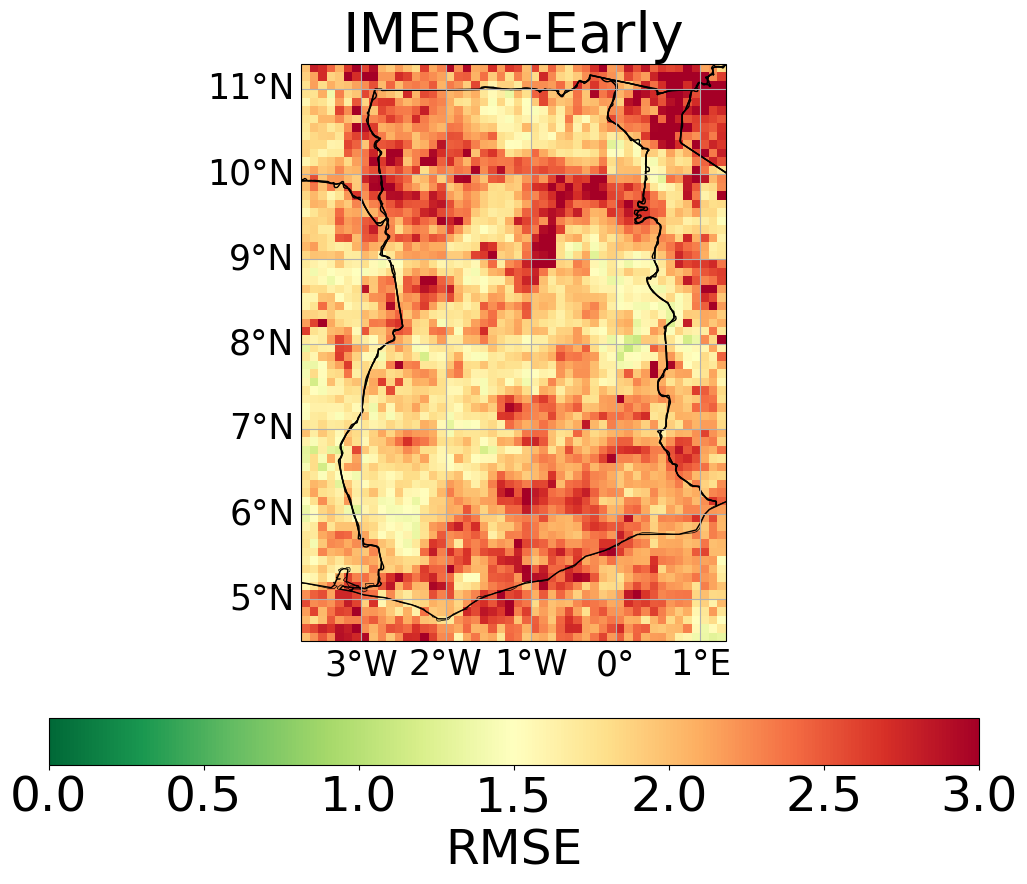

In [14]:
ds = xr.open_dataset(file_path_out, engine = 'netcdf4')    

# plt.figure(figsize=(9, 10))
# ds['y_hat'].plot(cmap=custom_cmap, norm=custom_norm)

# # Create the plot
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.title('IMERG-Early', fontsize = 40)

# Plot the SEVIRI data
data = ds['RMSE'][:] # Replace 'y_hat' with the actual variable name in your dataset
data = np.squeeze(data) #np.flipud?
mesh = ax.pcolormesh(grid_lon_2d, grid_lat_2d, data, cmap='RdYlGn_r', vmin=0., vmax=3, transform=ccrs.PlateCarree())

# Add borders, rivers, and coastlines
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m'),
               edgecolor='black', facecolor='none')
# ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m'),
#                edgecolor='blue', facecolor='none', linewidth=0.5)

# Add gridlines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False

# Customize gridline label font size and padding
gl.xlabel_style = {'size': 25, 'rotation': 0}  # Longitude label style
gl.ylabel_style = {'size': 25, 'rotation': 0}  # Latitude label style

# Add and customize colorbar
cbar = fig.colorbar(mesh, ax=ax, orientation='horizontal', pad=0.1)
cbar.set_label('RMSE', fontsize=35)
cbar.ax.tick_params(labelsize=35)  # Adjust tick label size

# # Add a colorbar
# cbar = fig.colorbar(mesh, ax=ax, orientation='horizontal', pad=0.05)
# cbar.set_label('RMSE', fontsize = 20)  # Replace with appropriate label

plt.savefig('RMSE_test_IMERG.png')
# Show the plot
#plt.title('SEVIRI Data with Borders and Rivers')
plt.show()